In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
big5 = pd.read_csv(r"C:\Users\anato\Documents\IRONHACK\IronFrandre\Project 4 European big 5\bundesliga-match-scores.csv")
big5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1540 non-null   int64  
 1   round       1540 non-null   object 
 2   day         1540 non-null   object 
 3   date        1540 non-null   object 
 4   time        1540 non-null   object 
 5   home        1540 non-null   object 
 6   xg_home     1534 non-null   float64
 7   score       1540 non-null   object 
 8   xg_away     1534 non-null   float64
 9   away        1540 non-null   object 
 10  attendance  1164 non-null   float64
 11  venue       1540 non-null   object 
 12  referee     1530 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 156.5+ KB


In [4]:
attendance_to_venue = big5[['attendance', 'venue']].groupby(by='venue', as_index = False).agg(np.mean)
for stade in attendance_to_venue['venue'] :
    if stade != 'Voith-Arena' :
        mean_attendance = int(attendance_to_venue.loc[attendance_to_venue['venue'] == stade, 'attendance'])
        big5.loc[(big5['attendance'].isna()) & (big5['venue'] == stade), 'attendance'] = mean_attendance
big5.loc[(big5['attendance'].isna()) & (big5['venue'] == 'Voith-Arena'), 'attendance'] = 7788

In [5]:
big5['score_home'] = big5['score'].apply(lambda s : int(s[0]))
big5['score_away'] = big5['score'].apply(lambda s : int(s[2]))

In [6]:
xghome_to_score = big5[['score_home', 'xg_home']].groupby(by='score_home', as_index = False).agg(np.mean)
for score in xghome_to_score['score_home'] :
    mean_xg = float(xghome_to_score.loc[xghome_to_score['score_home'] == score, 'xg_home'])
    big5.loc[(big5['xg_home'].isna()) & (big5['score_home'] == score), 'xg_home'] = mean_xg

In [7]:
xgaway_to_score = big5[['score_away', 'xg_away']].groupby(by='score_away', as_index = False).agg(np.mean)
for score in xgaway_to_score['score_away'] :
    mean_xg = float(xgaway_to_score.loc[xgaway_to_score['score_away'] == score, 'xg_away'])
    big5.loc[(big5['xg_away'].isna()) & (big5['score_away'] == score), 'xg_away'] = mean_xg

In [8]:
big5['referee'].fillna('Unknown', inplace = True)

big5.duplicated().value_counts()

False    1540
dtype: int64

In [9]:
big5.drop(['Unnamed: 0', 'round'], axis = 1, inplace = True)

In [10]:
def season(date_str) :
    month = int(date_str[5:7])
    if month < 8 :
        return int(date_str[0:4]) - 1
    else :
        return int(date_str[0:4])
    
big5['season'] = big5['date'].apply(season)

In [11]:
big5['home'].value_counts()
big5['away'].value_counts()
big5['referee'].value_counts()
big5['season'].value_counts()

2021    308
2020    308
2019    308
2018    308
2017    308
Name: season, dtype: int64

In [12]:
score_win = np.vectorize(max)(big5['score_home'], big5['score_away'])
score_win

array([1, 1, 0, ..., 4, 3, 1], dtype=int64)

In [13]:
score_win_count = pd.DataFrame(score_win).value_counts()
score_win_count
indexes = [item[0] for item in score_win_count.index]

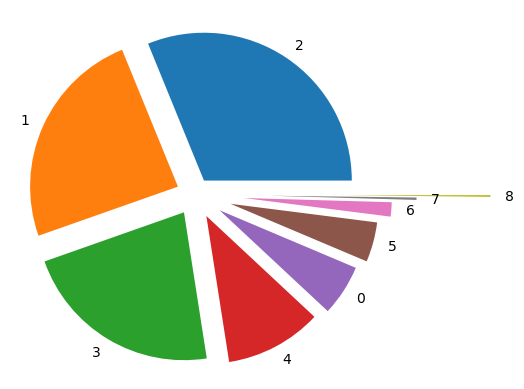

In [14]:
plt.pie(pd.DataFrame(score_win).value_counts(), labels = indexes, explode = [1/(len(indexes) - i) for i in range(len(indexes))])
plt.show()

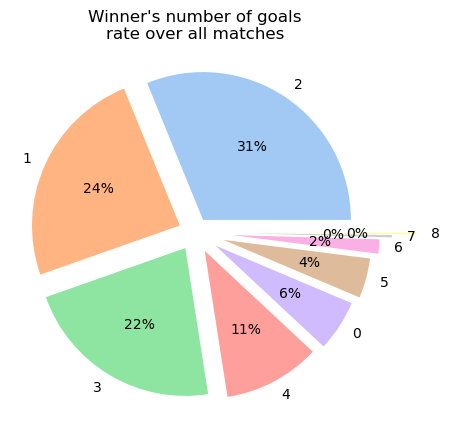

In [15]:
colors = sns.color_palette('pastel')

#Pie chart "Winner's number of goals\nrate over all matches"

plt.title("Winner's number of goals\nrate over all matches")
plt.pie(pd.DataFrame(score_win).value_counts(), colors = colors, labels = indexes, autopct = '%.0f%%', explode = [1/(len(indexes) - i + 1) for i in range(len(indexes))])
plt.show()

In [16]:
total_goals = big5[['season']]
total_goals['goals'] = big5['score_home'] + big5['score_away']

C:\Users\anato\AppData\Local\Temp\ipykernel_7772\3015156380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_goals['goals'] = big5['score_home'] + big5['score_away']


Text(0.5, 1.0, 'Number of goals per match\nboxplot for each season')

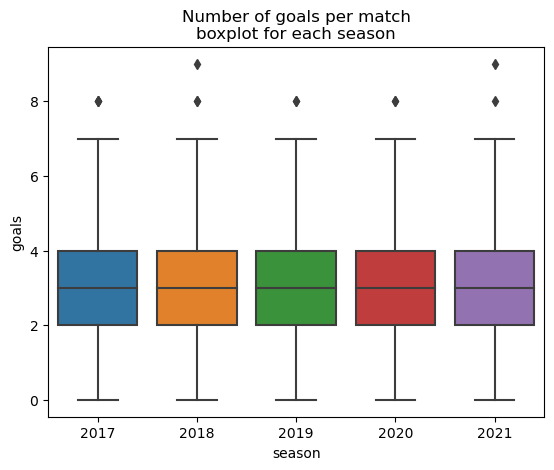

In [17]:
sns.boxplot(x='season', y = 'goals', data = total_goals).set_title('Number of goals per match\nboxplot for each season')

In [18]:
def points(score) :
    p_h = score[0]
    p_a = score[2]
    if p_h > p_a :
        return 3
    elif p_h == p_a :
        return 1
    else :
        return 0
    
big5['points_home'] = big5['score'].apply(points)


In [19]:
def points_away(score):
    if score == 3 :
        return 0
    elif score == 1 :
        return 1
    else :
        return 3

big5['points_away'] = big5['points_home'].apply(points_away)

In [20]:
ranks = big5.groupby(by = ['season', 'home'], as_index = False).agg(np.sum)[['season', 'home', 'points_home']]
ranks['points_away'] = big5.groupby(by = ['season', 'away'], as_index = False).agg(np.sum)['points_away']
ranks['total'] = ranks['points_home'] + ranks['points_away']

ranks.sort_values(by = ['season', 'total'], inplace = True, ascending = False)

ranks.loc[ranks['season'] == 2019, ['season', 'home', 'total']].head()

,season,home,total
39,2019,Bayern Munich,82
40,2019,Dortmund,69
52,2019,RB Leipzig,66
49,2019,M'Gladbach,65
48,2019,Leverkusen,63


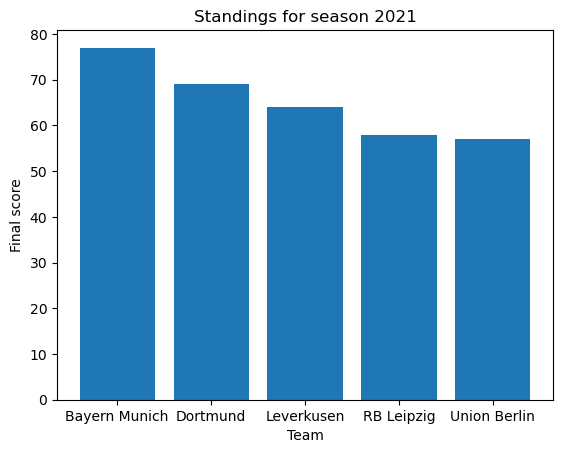

In [21]:
plt.bar(ranks.loc[ranks['season'] == 2021, 'home'][0:5], ranks.loc[ranks['season'] == 2021, 'total'][0:5])
plt.xlabel('Team')
plt.ylabel('Final score')
plt.title('Standings for season 2021')
plt.show()

In [22]:
xaxis_2017 = [i - 2 for i in range(0, 50, 10)]
xaxis_2018 = [i - 1 for i in range(0, 50, 10)]
xaxis_2019 = [i for i in range(0, 50, 10)]
xaxis_2020 = [i + 1 for i in range(0, 50, 10)]
xaxis_2021 = [i + 2 for i in range(0, 50, 10)]

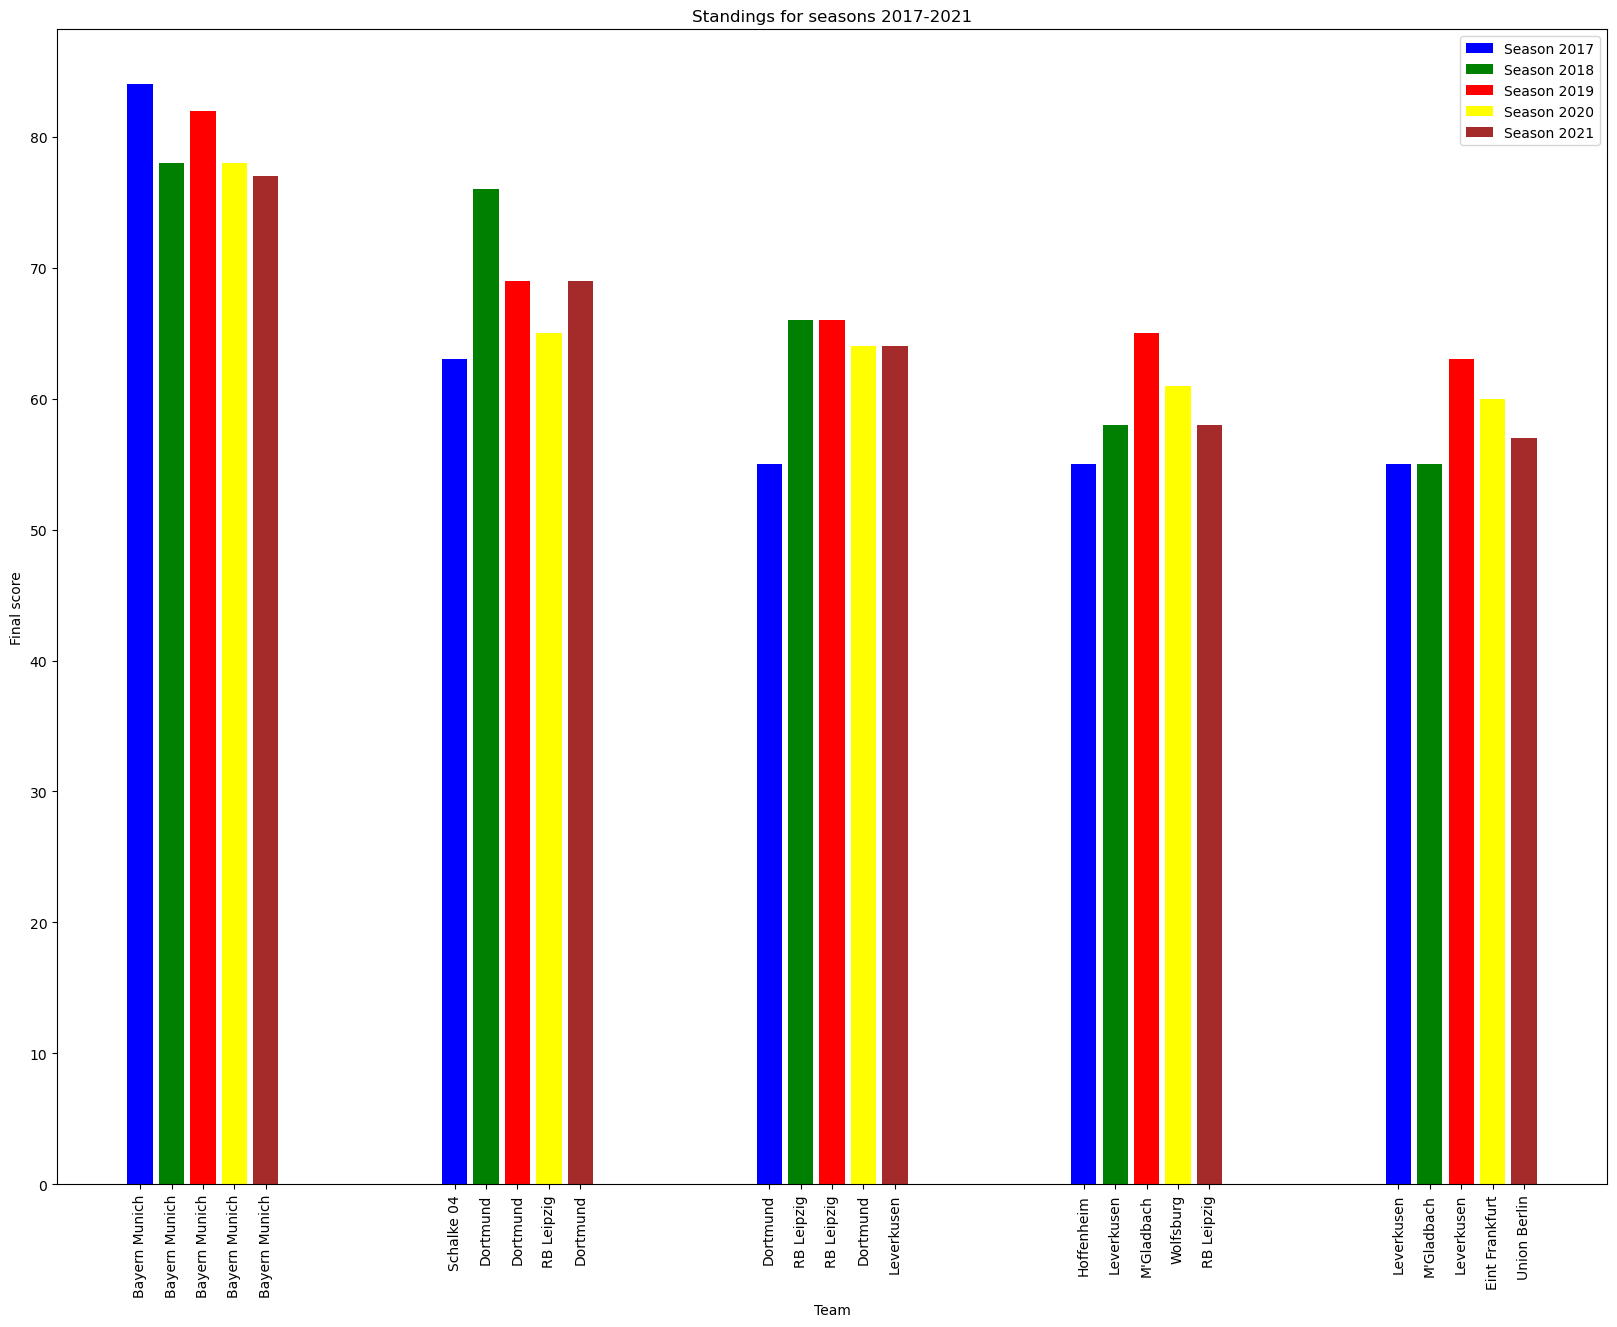

In [23]:
plt.figure(figsize = (20,15))
plt.bar(xaxis_2017, ranks.loc[ranks['season'] == 2017, 'total'][0:5], color = 'blue', label = 'Season 2017')
plt.bar(xaxis_2018, ranks.loc[ranks['season'] == 2018, 'total'][0:5], color = 'green', label = 'Season 2018')
plt.bar(xaxis_2019, ranks.loc[ranks['season'] == 2019, 'total'][0:5], color = 'red', label = 'Season 2019')
plt.bar(xaxis_2020, ranks.loc[ranks['season'] == 2020, 'total'][0:5], color = 'yellow', label = 'Season 2020')
plt.bar(xaxis_2021, ranks.loc[ranks['season'] == 2021, 'total'][0:5], color = 'brown', label = 'Season 2021')
plt.xticks(xaxis_2017+xaxis_2018+xaxis_2019+xaxis_2020+xaxis_2021, pd.concat([ranks.loc[ranks['season'] == 2017, 'home'][0:5], ranks.loc[ranks['season'] == 2018, 'home'][0:5], ranks.loc[ranks['season'] == 2019, 'home'][0:5], ranks.loc[ranks['season'] == 2020, 'home'][0:5], ranks.loc[ranks['season'] == 2021, 'home'][0:5]], ignore_index = True), rotation = 90)
plt.xlabel('Team')
plt.ylabel('Final score')
plt.title('Standings for seasons 2017-2021')
plt.legend()
plt.show()

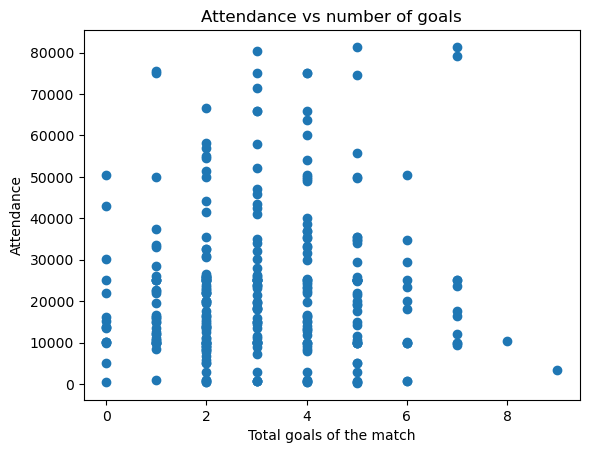

In [24]:
plt.scatter(total_goals.loc[total_goals['season'] == 2021, 'goals'], big5.loc[big5['season'] == 2021, 'attendance'])
plt.xlabel('Total goals of the match')
plt.ylabel('Attendance')
plt.title('Attendance vs number of goals')
plt.show()

In [25]:
xaxis_scatter3d = [i for i in range(9) for j in range(9)]
yaxis_scatter3d = [j for i in range(9) for j in range(9)]
zaxis_scatter3d = [big5.loc[big5['score'] == '–'.join([str(i), str(j)])].shape[0] for i in range(9) for j in range(9)]

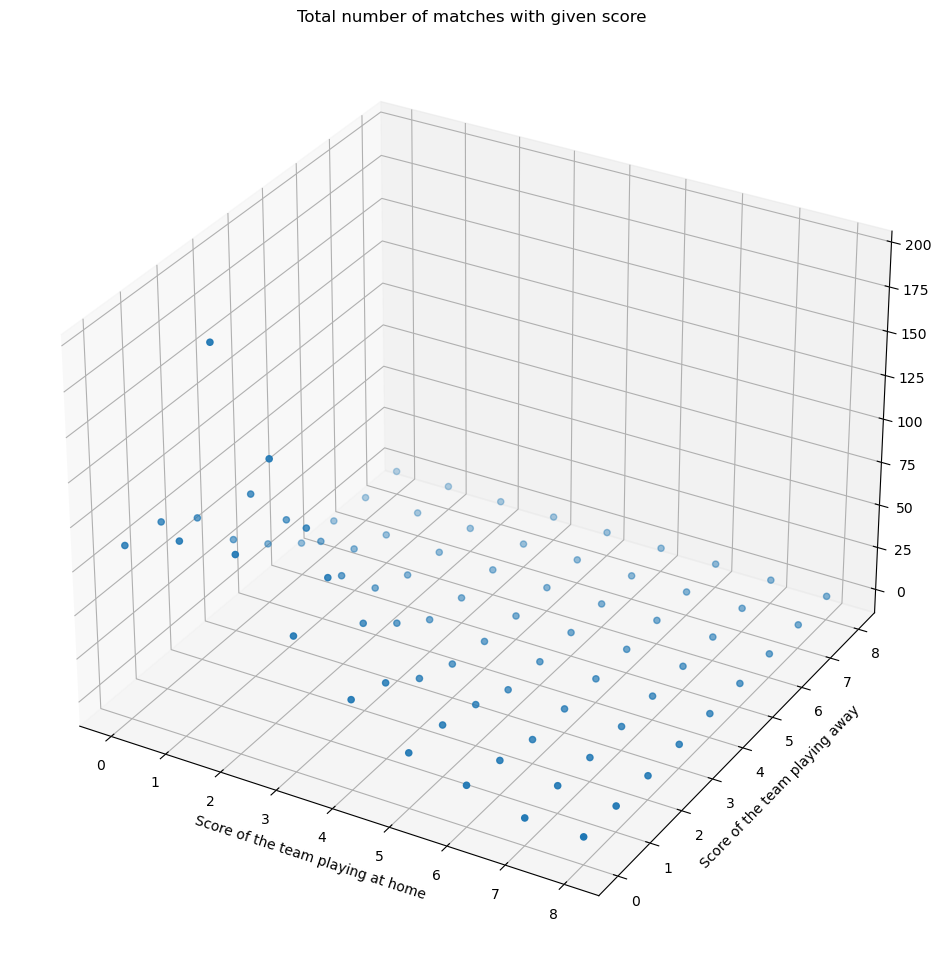

In [26]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xaxis_scatter3d, yaxis_scatter3d, zaxis_scatter3d)
plt.title('Total number of matches with given score')
plt.xlabel('Score of the team playing at home')
plt.ylabel('Score of the team playing away')
plt.show()

In [27]:
bayern_home = big5.loc[(big5['home'] == 'Bayern Munich') & (big5['season'] == 2021), ['away', 'points_home']].sort_values(by = 'away')
bayern_away = big5.loc[(big5['away'] == 'Bayern Munich') & (big5['season'] == 2021), ['home', 'points_away']].sort_values(by = 'home')
bayern_home.set_index(pd.Series(range(17)), inplace = True)
bayern_away.set_index(pd.Series(range(17)), inplace = True)
bayern = bayern_home['points_home'] + bayern_away['points_away']
bayern[17] = 6

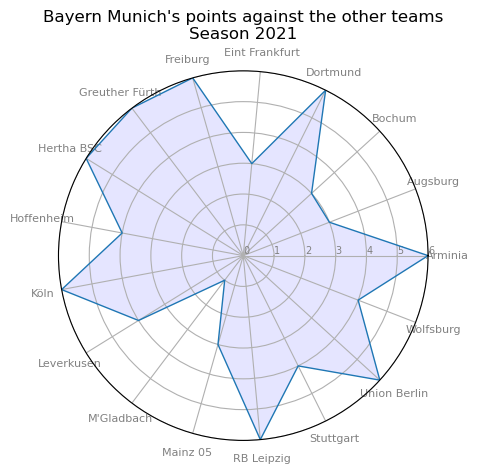

In [28]:
# Libraries
from math import pi
 
# Set data
#df = pd.DataFrame({
#'group': ['A','B','C','D'],
#'var1': [38, 1.5, 30, 4],
#'var2': [29, 10, 9, 34],
#'var3': [8, 39, 23, 24],
#'var4': [7, 31, 33, 14],
#'var5': [28, 15, 32, 14]
#})
 
# number of variable
categories=bayern_home['away']
N = 17
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
#values=df.loc[0].drop('group').values.flatten().tolist()
#values += values[:1]
#values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(range(7), ['0', '1', '2', '3', '4', '5', '6'], color="grey", size=7)
plt.ylim(0,6)
 
# Plot data
ax.plot(angles, bayern, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, bayern, 'b', alpha=0.1)

# Show the graph
plt.title("Bayern Munich's points against the other teams\nSeason 2021")
plt.show()